In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from sklearn.metrics import mean_squared_error

import compressai
from Iwildcam_Pretrain import CompressaiWrapper, Autoencoder, IWildCamDataset
from lora_modules import LoRAConv2d, LoRALinear, LoRAConvTranspose2d

/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)
[rank: 0] Seed set to 42


Device: cuda:0


In [3]:
USE_WEBCAM = False  # Set to True to capture live data using your webcam
USE_MPS = True
CHECKPOINT_PATH = "best_checkpoints/"
DO_CACHING = False
DATASET_ROOT = "/tmp/iwildcam_unzipped"

if USE_MPS and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend")
else:
    device = torch.device("cpu")
print("Device:", device)

Device: cpu


In [4]:
loraize_encoder = False  # no reason really to do this unless we want to reduce memory footprint
loraize_decoder = True 

lora_config = {
    torch.nn.Conv2d: {
        'cls': LoRAConv2d,
        'config': {
            'alpha': 8,
            'rank': 4,
            'rank_for': 'channels',
            'delta_bias': False # True # TODO what does this do
        }
    },
    torch.nn.Linear: {
        'cls': LoRALinear,
        'config': {
            'rank': 4,
            'alpha': 2,
            'delta_bias':  False # True # TODO what does this do
        }
    },
    torch.nn.ConvTranspose2d: {
        'cls': LoRAConvTranspose2d,
        'config': {
            'alpha': 8,
            'rank': 4,
            'rank_for': 'channels',
            'delta_bias': False # True # TODO what does this do
        }
    }
}

def get_lora_model(
        latent_dim,
        lora_precision=None,
        loraize_encoder = False,  # no reason really to do this unless we want to reduce memory footprint
        loraize_decoder = True,
        finetune = True,
        model_type = 'hyperprior',
):
    if finetune and lora_precision == 32:
        lora_precision = None

    lora_config = {
        torch.nn.Conv2d: {
            'cls': LoRAConv2d,
            'config': {
                'alpha': 8,
                'rank': 4,
                'rank_for': 'channels',
                'delta_bias': False, # True # TODO what does this do
                'precision': lora_precision,
            }
        },
        torch.nn.Linear: {
            'cls': LoRALinear,
            'config': {
                'rank': 4,
                'alpha': 2,
                'delta_bias':  False, # True # TODO what does this do
                'precision': lora_precision,
            }
        },
        torch.nn.ConvTranspose2d: {
            'cls': LoRAConvTranspose2d,
            'config': {
                'alpha': 8,
                'rank': 4,
                'rank_for': 'channels',
                'delta_bias': False, # True # TODO what does this do
                'precision': lora_precision,
            }
        }
    }

    # load two copies so we can lora-ize one
    if model_type == 'vanilla':
        pretrained_filename = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, f"{latent_dim}-*.ckpt")))[0]
        if os.path.isfile(pretrained_filename):
            print(f"Found pretrained model '{pretrained_filename}' for latent dim {latent_dim}, loading...")
            _model = Autoencoder.load_from_checkpoint(pretrained_filename)
            model  = Autoencoder.load_from_checkpoint(pretrained_filename)
        else:
            raise Exception
    elif model_type == 'hyperprior':
        pretrained_filename = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, f"{latent_dim}-*.ckpt")))[0]
        if os.path.isfile(pretrained_filename):
            print(f"Found pretrained model '{pretrained_filename}' for latent dim {latent_dim}, loading...")
            model  = CompressaiWrapper.load_from_checkpoint(pretrained_filename)
            _model = CompressaiWrapper.load_from_checkpoint(pretrained_filename)
        else:
            raise Exception
    else:
        raise ValueError('Invalid model_type')
    
    if not finetune:
        return model
    
    if model_type == 'vanilla':
        if loraize_encoder:
            for i, module in enumerate(_model.encoder.net.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.encoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.encoder.net[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)

        if loraize_decoder:
            for i, module in enumerate(_model.decoder.linear.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.decoder.linear[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.decoder.linear[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)

            for i, module in enumerate(_model.decoder.net.children()): 
                if type(module) in lora_config.keys():
                    lora_cls = lora_config[type(module)]['cls']
                    lora_params = lora_config[type(module)]['config']
                    model.decoder.net[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                    model.decoder.net[i].enable_adapter()                # but we need to turn on the adapter path
                else:
                    # freeze all other parameters
                    for p in module.parameters():
                        p.requires_grad_(False)
    
    elif model_type == 'hyperprior':
            # freeze decoder stuff that won't be transmitted
        print("Freezing:")
        for name, param in model.model.g_s.named_parameters():
            print(name)
            param.requires_grad = False
        for name, param in model.model.h_s.named_parameters():
            print(name)
            param.requires_grad = False

        print("Fine-tuning:")
        for i, module in enumerate(_model.model.g_s.children()): 
            if type(module) in lora_config.keys():
                print("lora-izing", module)
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.model.g_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.model.g_s[i].enable_adapter()                # but we need to turn on the adapter path

        for i, module in enumerate(_model.model.h_s.children()): 
            if type(module) in lora_config.keys():
                print("lora-izing", module)
                lora_cls = lora_config[type(module)]['cls']
                lora_params = lora_config[type(module)]['config']
                model.model.h_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
                model.model.h_s[i].enable_adapter()                # but we need to turn on the adapter path
    else:
        raise ValueError('Invalid model_type')

    del _model # get rid of the clone
    return model

In [5]:
model = get_lora_model(8, 8, finetune=True)

Found pretrained model 'best_checkpoints/8-epoch=04-val_loss=0.01.ckpt' for latent dim 8, loading...
Freezing:
0.weight
0.bias
1.beta
1.gamma
2.weight
2.bias
3.beta
3.gamma
4.weight
4.bias
5.beta
5.gamma
6.weight
6.bias
0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
Fine-tuning:
lora-izing ConvTranspose2d(8, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing ConvTranspose2d(192, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
lora-izing Conv2d(192, 8, kernel_size=(3, 3), stride=(1, 

/data/vision/beery/scratch/timm/micromamba/envs/aecompression/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

%matplotlib inline

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def capture_images(num=8, warmup_frames=5, secs_bw_cap=0.1):
    cap = cv2.VideoCapture(0)
    
    # warm-up the camera
    for _ in range(warmup_frames):
        cap.read()
    
    images = []
    for i in range(num):
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to capture frame {i}")
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # needs to be divisible by 16 for compressai model
        h, w, _ = frame.shape
        new_h = (h + 15) // 16 * 16 
        new_w = (w + 15) // 16 * 16 
        frame = cv2.resize(frame, (new_w, new_h))

        # convert to tensor: [C, H, W]
        tensor = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
        images.append(tensor.unsqueeze(0))  # [1, C, H, W]

        time.sleep(secs_bw_cap)
    
    cap.release()
    return torch.cat(images, dim=0)  # [N, C, H, W]

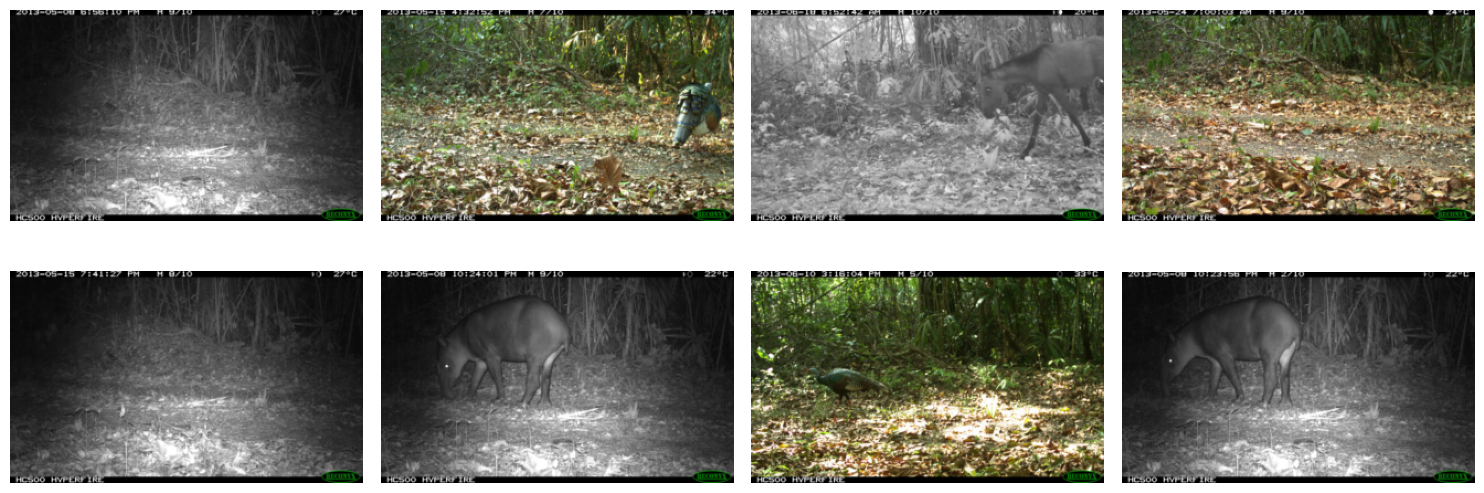

In [7]:
NUM_IMAGES = 8
if USE_WEBCAM:
    # Capture some images using the webcam
    images = capture_images(NUM_IMAGES).to(device)
else:
    # Load some images from the test set
    loc_id = 20
    test_set = IWildCamDataset(Path(DATASET_ROOT), split="test")
    if DO_CACHING:
        test_set.cache_on_device_(device)
        test_set._cache = test_set._cache[[idx for idx, i in enumerate(test_set.data['images']) if i['location'] == loc_id]]
    test_set.data['images'] = [i for i in test_set.data['images'] if i['location'] == loc_id]
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=16 if not DO_CACHING else 0)
    images = torch.stack([test_set[i] for i in np.random.default_rng(seed=1).integers(0, len(test_set), 8)], dim=0).to(device)

fig, axes = plt.subplots(2, NUM_IMAGES // 2, figsize=(15, 6))
for i in range(NUM_IMAGES):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = img.clip(0, 1)
    axes[i % 2, i // 2].imshow(img)
    axes[i % 2, i // 2].axis('off')

plt.tight_layout()

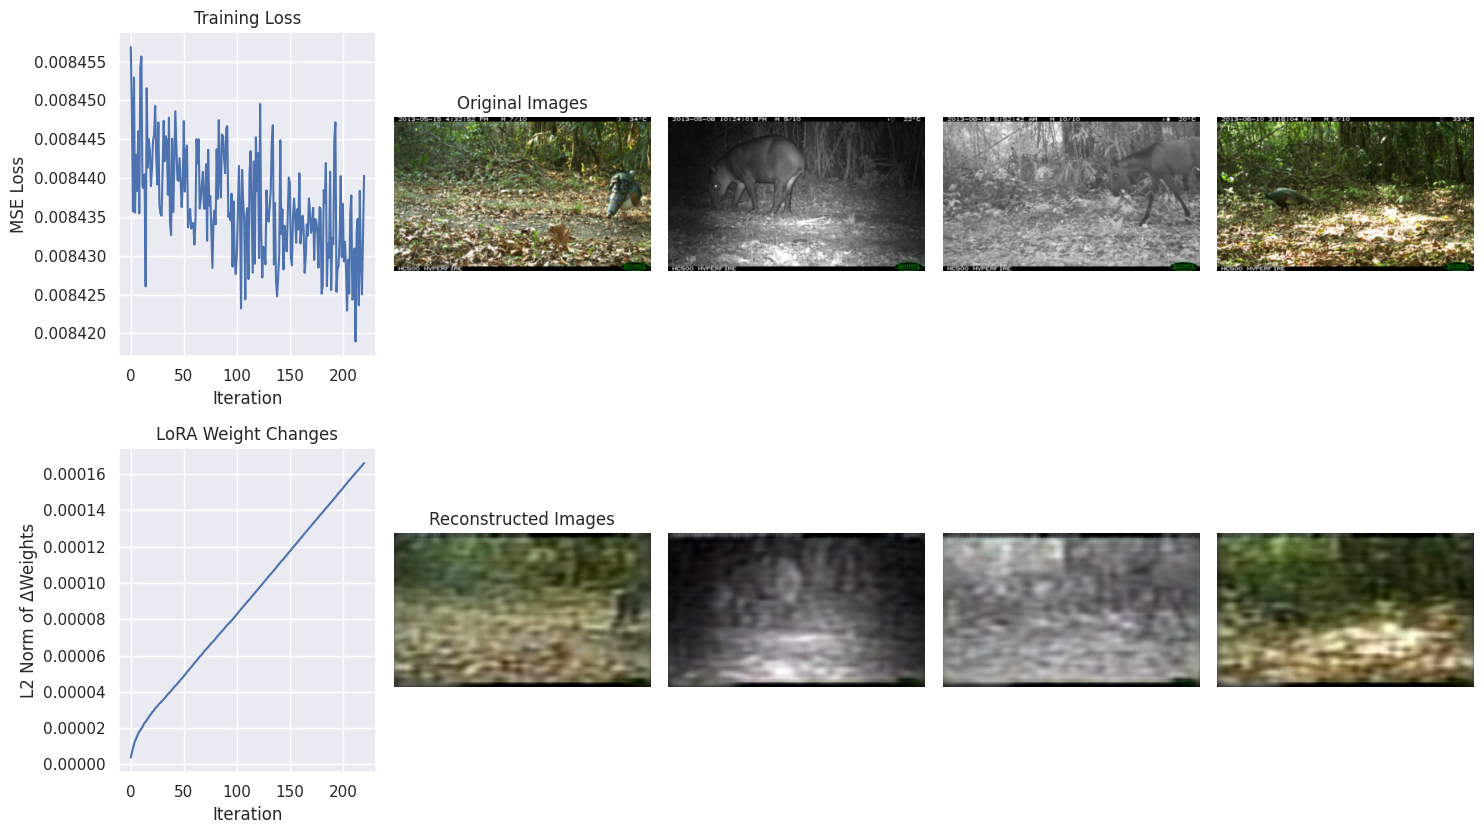

KeyboardInterrupt: 

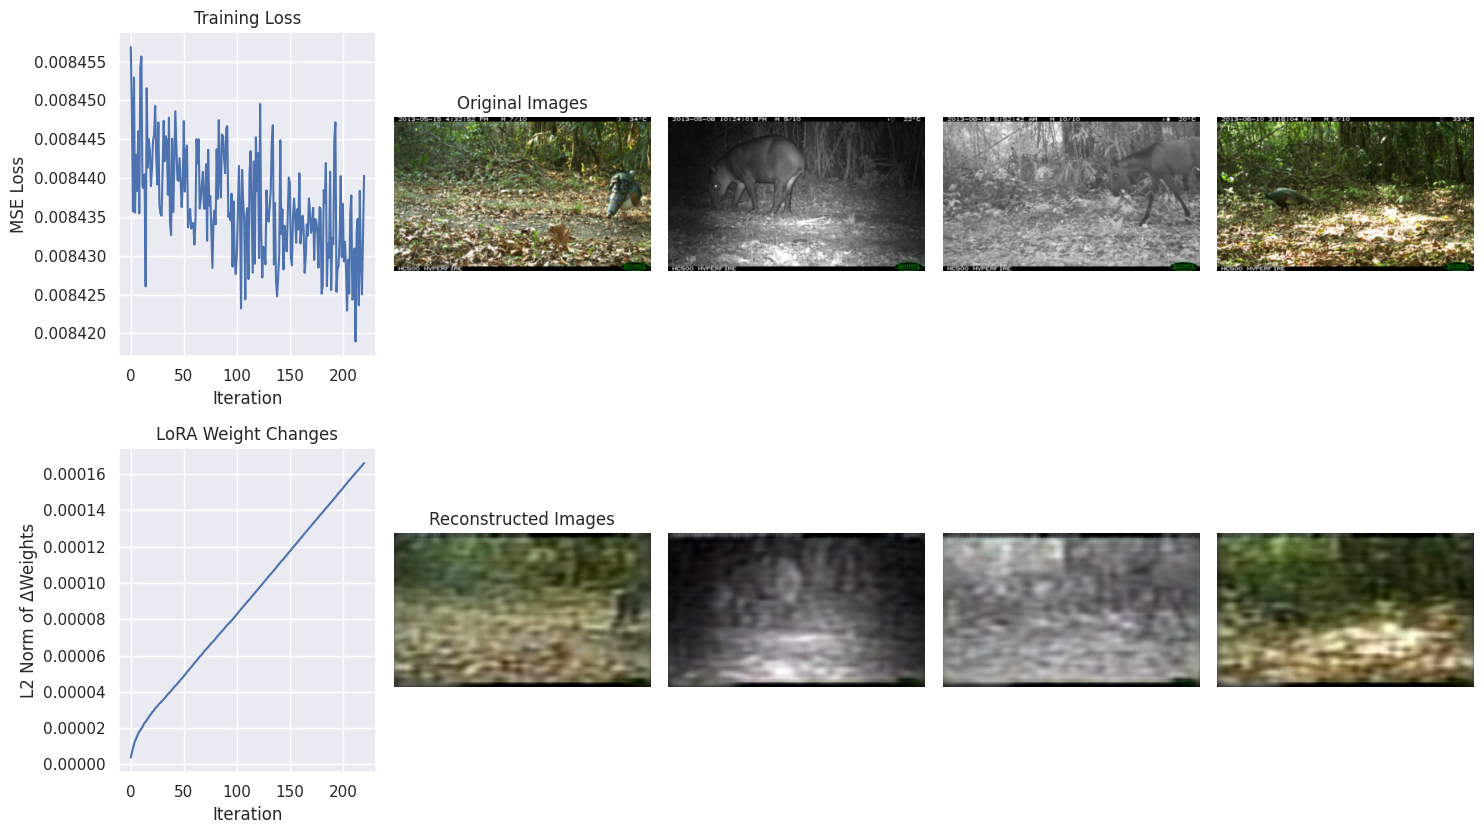

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

%matplotlib inline

model.to(device)
model.train()

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)
criterion = nn.MSELoss()

batch_size = 8
num_epochs = 600

lora_params_initial = {
    n: p.detach().cpu().clone() 
    for n, p in model.named_parameters() if "delta" in n.lower()
}
print("initial lora params:", lora_params_initial.keys())

# plot over time
lora_param_changes = []
losses = []

fig, axes = plt.subplots(2, 5, figsize=(15,8.5))
loss_ax = axes[0,0]
weights_ax = axes[1,0]
orig_axes = axes[0,1:]
recon_axes = axes[1,1:]

for epoch in range(num_epochs):
    for i in range(0, images.size(0), batch_size):
        img = images[i:i+batch_size].to(device)
        
        if not (USE_MPS and torch.backends.mps.is_available()):
            x_hat = model(img)
        else:
            # some operations not supported on mps, so we need to move things back and forth
            x = img
            y = model.g_a(x)
            z = model.h_a(torch.abs(y))
            z_hat, z_likelihoods = model.entropy_bottleneck(z)
            scales_hat = model.h_s(z_hat)

            # this op not supported on mps
            y = y.to("cpu")
            scales_hat = scales_hat.to("cpu")
            model = model.to("cpu")
            y_hat, y_likelihoods = model.gaussian_conditional(y, scales_hat)

            # put stuff back on mps for backward pass and loss
            y_hat = y_hat.to(device)
            model = model.to(device)
            
            x_hat = model.g_s(y_hat) #["x_hat"]
        
        loss = criterion(x_hat, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # get lora update norms
        current_lora_params = {
            n: p.detach().cpu().clone() 
            for n, p in model.named_parameters() if "delta_" in n.lower()
        }
        diff_norm = 0.0
        for n in lora_params_initial:
            diff_norm += (current_lora_params[n] - lora_params_initial[n]).pow(2).sum().item()
        diff_norm = diff_norm**0.5
        lora_param_changes.append(diff_norm)

        # update display
        clear_output(wait=True)

        # loss plot
        loss_ax.clear()
        loss_ax.plot(losses)
        loss_ax.set_title("Training Loss")
        loss_ax.set_xlabel("Iteration")
        loss_ax.set_ylabel("MSE Loss")

        # lora plot
        weights_ax.clear()
        weights_ax.plot(lora_param_changes)
        weights_ax.set_title("LoRA Weight Changes")
        weights_ax.set_xlabel("Iteration")
        weights_ax.set_ylabel("L2 Norm of ΔWeights")

        for j in range(4):
            orig_img_np = img[j+2].detach().cpu().permute(1,2,0).numpy().clip(0,1) # use middle 4 images
            x_hat_np = x_hat[j+2].detach().cpu().permute(1,2,0).numpy().clip(0,1) # use middle 4 images

            orig_axes[j].clear()
            orig_axes[j].imshow(orig_img_np)
            orig_axes[j].axis('off')
    
            recon_axes[j].clear()
            recon_axes[j].imshow(x_hat_np)
            recon_axes[j].axis('off')

        recon_axes[0].set_title("Reconstructed Images")
        orig_axes[0].set_title("Original Images")

        plt.tight_layout()
        os.makedirs("figures/demo_video", exist_ok=True)
        fig.savefig(f"figures/demo_video/epoch_{epoch:03d}.png")
        display(fig)
        # plt.pause(0.001)

print("done")

In [9]:
!ffmpeg -framerate 10 -pattern_type glob -i 'figures/demo_video/*.png' -c:v libx264 -pix_fmt yuv420p figures/demo_video.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1+esm5 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.4.0-1ubuntu1~22.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1+esm5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enabl